In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
data = pd.read_csv("medical_cost.csv")
len(data)

1338

In [16]:
data.head(5)

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges
0,1,19,female,27.900,0,yes,southwest,16884.92400
1,2,18,male,33.770,1,no,southeast,1725.55230
2,3,28,male,33.000,3,no,southeast,4449.46200
3,4,33,male,22.705,0,no,northwest,21984.47061
4,5,32,male,28.880,0,no,northwest,3866.85520


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [46]:
#checking for NaNs
data.isnull().sum()
#no NaNs found

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [48]:
#checking data types of features
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

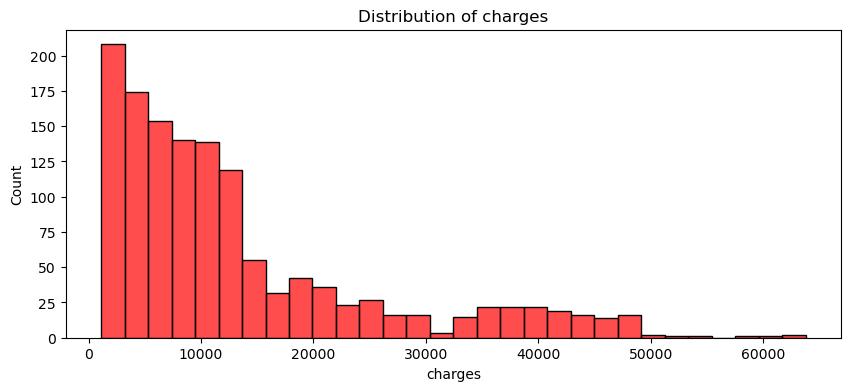

In [84]:
plt.figure(figsize=(10, 4))
sns.histplot(data['charges'], alpha = 0.7, color = 'red')
plt.title('Distribution of charges')
plt.show()
#this distribution of charges is skewed
#more people pay less, less people pay more

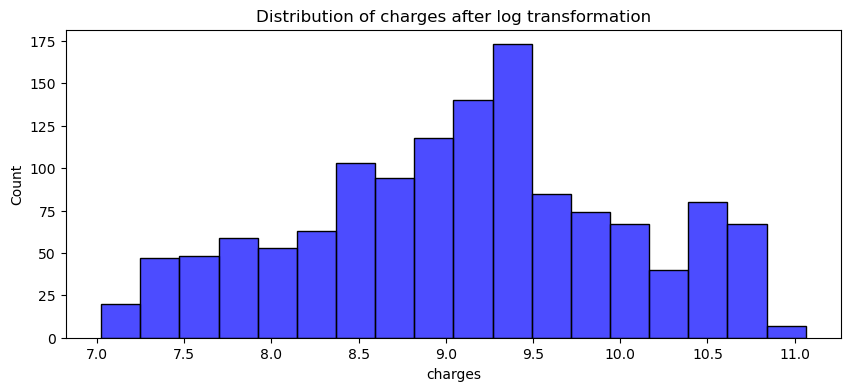

In [94]:
#plotting log transformed charges
plt.figure(figsize=(10, 4))
sns.histplot(np.log1p(data['charges']), alpha = 0.7, color = 'blue')
plt.title('Distribution of charges after log transformation')
plt.show()

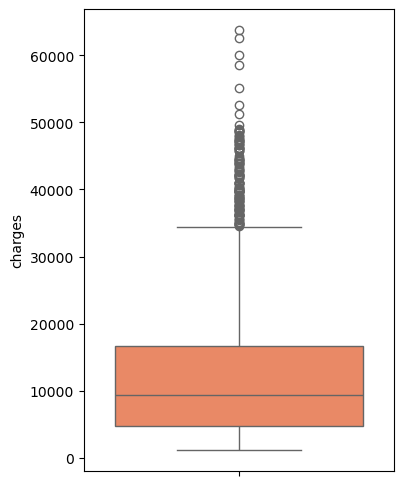

In [156]:
plt.figure(figsize = (4, 6))
sns.boxplot(data.charges, color = 'coral')
plt.show()

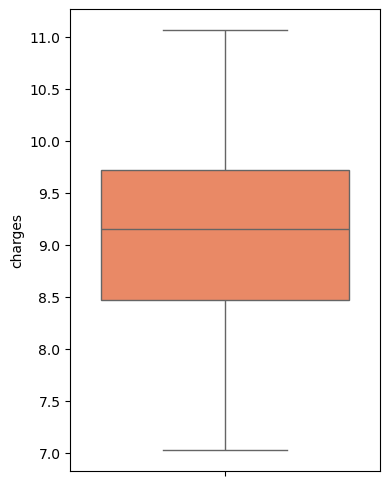

In [158]:
#log transformation pretty much normalizes the data, reducing extremes
plt.figure(figsize = (4, 6))
sns.boxplot(np.log1p(data.charges), color = 'coral')
plt.show()

In [162]:
#adding new col to data
data['log_charges'] = np.log1p(data.charges)
data.head(5)

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734236
1,18,male,33.770,1,no,southeast,1725.55230,7.453882
2,28,male,33.000,3,no,southeast,4449.46200,8.400763
3,33,male,22.705,0,no,northwest,21984.47061,9.998137
4,32,male,28.880,0,no,northwest,3866.85520,8.260455


In [164]:
data.log_charges.skew()
#very slightly negatively skewed after log transformation

-0.08981728740026824

In [296]:
#creating framework for validation

n = len(data)
val = int(0.2 * n)
test = int(0.2 * n)
train = n - (val + test)

#shuffling the data so similar categories aren't all clumped

np.random.seed(2)

ind = np.arange(n)
np.random.shuffle(ind)

data_shuffled = data.iloc[ind]

#doing a 60-20-20 split

train_dat = data_shuffled[:train].copy()
val_dat = data_shuffled[train:train+val].copy()
test_dat = data_shuffled[train+val:].copy()

In [298]:
#extracting charges for training, validation and testing
y_train = train_dat.log_charges.values
y_val = val_dat.log_charges.values
y_test = test_dat.log_charges.values

n == y_train.shape[0] + y_val.shape[0] + y_test.shape[0] #should be true

True

In [440]:
#feature engineering
#BMI, children and age already numeric
#sex and smoker need one-hot encoding

def feature_eng(df):
    df = df.copy()
    df.loc[:, 'female'] = (df['sex'] == 'female').astype(int)
    df.loc[:, 'smoke'] = (df['smoker'] == 'yes').astype(int)
    df.loc[:, 'bmi-smoke'] = (df['smoke'] * df['bmi'])
    df.loc[:, 'bmi-smoke-sq'] = (df['bmi-smoke'] ** 2)
    df.loc[:, 'bmi-sq'] = (df['bmi'] ** 2)
    features = ['smoke', 'female', 'bmi','age', 'children', 'bmi-smoke', 'bmi-smoke-sq', 'bmi-sq']
    return df[features]

In [442]:
#getting features
x_train = feature_eng(train_dat).values
x_val = feature_eng(val_dat).values
x_test = feature_eng(test_dat).values

x_train.shape[0] + x_val.shape[0] + x_test.shape[0] == n  #should be true

True

In [444]:
#adding bias term
x_train = np.column_stack([np.ones(x_train.shape[0]), x_train])
x_test = np.column_stack([np.ones(x_test.shape[0]), x_test])
x_val = np.column_stack([np.ones(x_val.shape[0]), x_val])

In [446]:
#lin regression model
def train_reg (x,y):
    xtx = x.T.dot(x)
    xtx_inv = np.linalg.inv(xtx)
    w = xtx_inv.dot(x.T).dot(y)
    return w

In [448]:
#prediction
def predict(x,w):
    return x.dot(w)

In [450]:
def rmse(y, y_pred):
    se = (y-y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [452]:
#training the model
w = train_reg(x_train, y_train)
y_pred = predict(x_val, w)
y_pred_test  = predict(x_test, w)

In [454]:
# calculating rmse
print('RMSE FOR TRAINING:', rmse(y_train, predict(x_train, w)))
print('RMSE FOR VAL:', rmse(y_val, predict(x_val, w)))
print('RMSE FOR TESTING:', rmse(y_test, predict(x_test, w)))

RMSE FOR TRAINING: 0.41050912009205515
RMSE FOR VAL: 0.5096107654116868
RMSE FOR TESTING: 0.40731416049404184


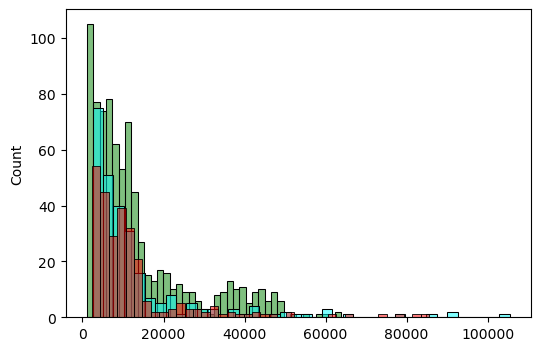

In [456]:
plt.figure(figsize= (6,4))

sns.histplot(np.expm1(y_train), label = 'target', alpha = 0.5, color = 'green', bins = 40)
sns.histplot(np.expm1(y_pred), label = 'prediction', alpha = 0.5, color = 'cyan', bins = 40)
sns.histplot(np.expm1(y_pred_test), label ='test', alpha = 0.5, color = 'red', bins = 40)

plt.show()

In [466]:
#using the model
x = {'smoker' : 'yes',
     'sex': 'male',
     'bmi': 28.008,
     'age': 33,
     'children': 3}

prep_data = feature_eng(pd.DataFrame([x]))
prep_data

,smoke,female,bmi,age,children,bmi-smoke,bmi-smoke-sq,bmi-sq
0,1,0,28.008,33,3,28.008,784.448064,784.448064


In [486]:
x2 = prep_data.values
add_bias = np.column_stack([np.ones(x2.shape[0]), x2])
predict_cost = predict(add_bias, w)
final_pred = np.expm1(predict_cost)

In [490]:
final_pred[0]

26295.2429809893